# Starfish: PHOENIX Model Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import os

import warnings
import astropy.units as u

from muler.igrins import IGRINSSpectrum, IGRINSSpectrumList

from Starfish.grid_tools import PHOENIXGridInterfaceNoAlpha, HDF5Creator
from Starfish.grid_tools.instruments import SPEX, IGRINS_K, IGRINS
from Starfish.emulator.plotting import plot_emulator, plot_eigenspectra
from Starfish.emulator import Emulator
from Starfish.spectrum import Spectrum
from Starfish.models import SpectrumModel

import scipy.stats as st

import emcee
import arviz as az
import corner

from tqdm import tqdm

# from gollum.phoenix import PHOENIXSpectrum, PHOENIXGrid

from astropy.io import fits

# Plotting Parameters
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']= 'bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

%matplotlib inline

In [2]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

# Reduced and order-merged data filepath 
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"

# File path for figures to live in
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"

# PHOENIX Models path
phoenix_mod_path = "C:\\Users\\Savio\\Documents\\Research\\phoenix_models\\phoenix.astro.physik.uni-goettingen.de\\HiResFITS\\PHOENIX-ACES-AGSS-COND-2011\\"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
# merged_standard_files = glob.glob(data_path + "/merged_standards/m*.fits")
standard_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\standard_table_v3.txt', index_col=0)  # csv of standards with file and Spectral Type, c/v TBA
# just a pick a sequence of standards to look at: ["LkCa1","HBC427","Hubble4","Anon1","LkCa5","MHO8"])]
# Symposium sequence: ["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"]
standard_table = standard_table[standard_table['Name'].isin(["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"])].reset_index(drop=True)

proto_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\protostar_table.txt', index_col=0)

standards_path = standard_table['File']
standard_list = standard_table['File'].values

proto_path = proto_table['File']
proto_list = proto_table['File'].values

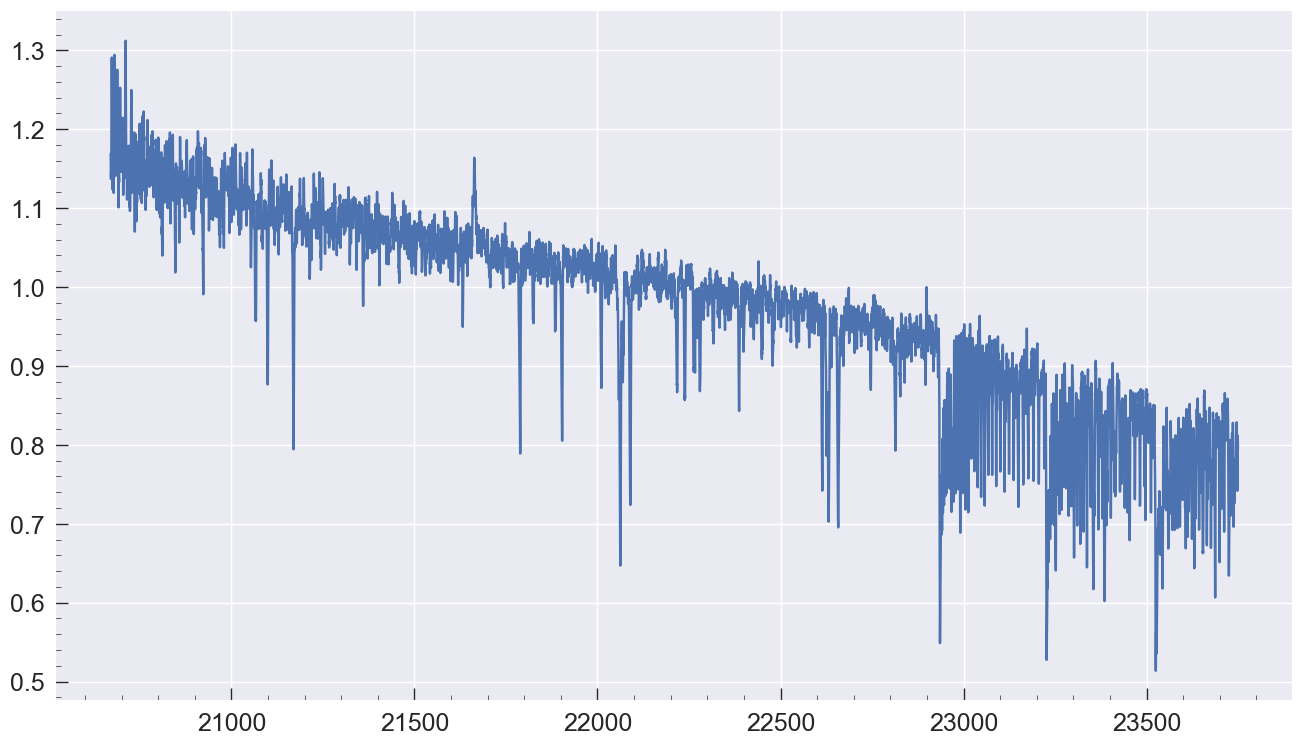

In [3]:
spec = IGRINSSpectrumList.read(standard_table['File'][2])\
    .trim_overlap().stitch().remove_nans()

spec = spec.apply_boolean_mask(
    mask=(~np.isnan(spec.wavelength.value)) &
    (spec.wavelength.value > 2.067*1e4) &
    (spec.wavelength.value < 2.375*1e4)
    ).normalize()

plt.plot(spec.wavelength, spec.flux)
# spec.plot()
# plt.xlim(2.15e4,2.25e4)
plt.show()

# Starfish Setup

In [36]:
from Starfish.grid_tools import download_PHOENIX_models

ranges = [[3000, 5300], [3.0, 6.0], [0, 0.5]]  # T, logg, Z

download_PHOENIX_models(path=phoenix_mod_path, ranges=ranges)


grid = PHOENIXGridInterfaceNoAlpha(path=phoenix_mod_path, wl_range=(18500, 24000))

lte05300-6.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits: 100%|██████████| 336/336 [00:00<00:00, 663.90it/s]


In [37]:
creator = HDF5Creator(
    grid,
    "starfish_hdf5\\F_IGRINS_grid.hdf5",
    instrument=IGRINS_K(),
    ranges=ranges
)
creator.process_grid()

Processing [5.3e+03 6.0e+00 5.0e-01]: 100%|██████████| 336/336 [01:26<00:00,  3.88it/s]


In [42]:
# can load from string or HDF5Interface
emu = Emulator.from_grid("starfish_hdf5\\F_IGRINS_grid.hdf5")

In [51]:
emu

Emulator
--------
Trained: False
lambda_xi: 1.000
Variances:
	34688.96
	18452.07
	5359.18
	20010.25
	3572.36
	4144.93
	7061.33
	1299.73
	10591.71
Lengthscales:
	[ 207.46  1.02  1.00 ]
	[ 202.43  1.01  1.00 ]
	[ 219.34  1.00  1.22 ]
	[ 426.91  1.33  1.14 ]
	[ 205.13  1.11  1.13 ]
	[ 200.00  1.81  1.00 ]
	[ 200.09  2.22  1.85 ]
	[ 212.35  1.16  1.01 ]
	[ 200.00  1.95  1.00 ]
Log Likelihood: -6002.14

In [52]:
%time emu.train()
emu

Optimization did not succeed.


CPU times: total: 4h 54min 25s
Wall time: 38min 35s


Emulator
--------
Trained: False
lambda_xi: 1.001
Variances:
	33902.46
	17734.83
	6184.16
	19018.06
	2995.02
	3951.38
	6280.28
	1020.62
	8995.20
Lengthscales:
	[ 206.96  1.02  1.00 ]
	[ 205.69  1.01  1.00 ]
	[ 223.17  1.00  1.08 ]
	[ 427.40  1.28  1.22 ]
	[ 200.00  1.11  1.04 ]
	[ 200.01  1.76  1.00 ]
	[ 200.00  2.19  1.73 ]
	[ 200.00  1.13  1.01 ]
	[ 200.16  1.90  1.00 ]
Log Likelihood: -5993.17

c:\Users\Savio\anaconda3\envs\starfish_env\lib\site-packages\Starfish\emulator\emulator.py:371: UserWarning: This emulator has not been trained and therefore is not reliable. call                     emulator.train() to train.
  warnings.warn(


KeyboardInterrupt: 

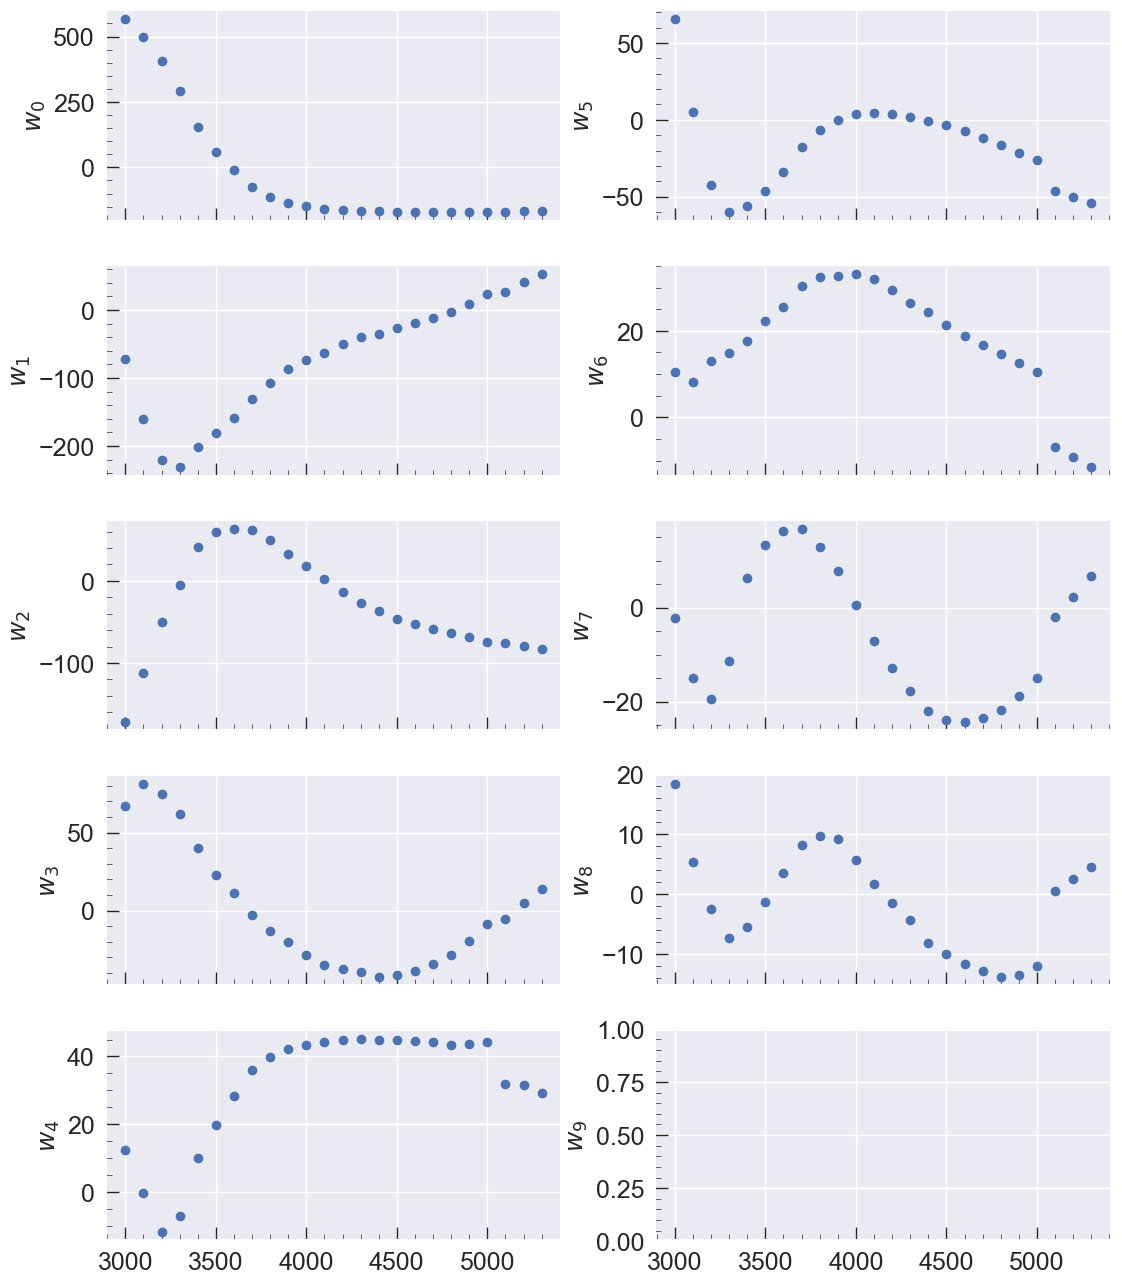

In [45]:
plot_emulator(emu)

In [18]:
emu.save("starfish_hdf5\\F_IGRINS_K_emu.hdf5")

# Single Order Spectrum

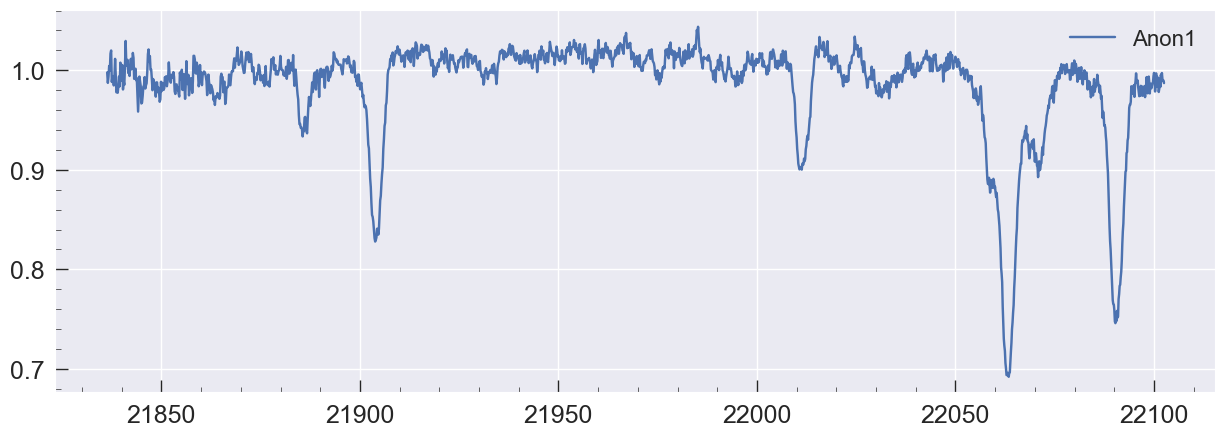

In [4]:
spec_n = 3
order = 14

spec = IGRINSSpectrumList.read(standard_table['File'][spec_n]).trim_overlap(pivot=0.45).remove_nans().normalize(order_index=order)

fig = plt.figure(figsize=(15,5))
plt.plot(spec[order].wavelength,spec[order].flux, label=f"{standard_table['Name'][spec_n]}")
plt.legend()
plt.show()

In [9]:
# spec.to_HDF5("starfish_hdf5\\",f"{standard_table['Name'][spec_n]}")

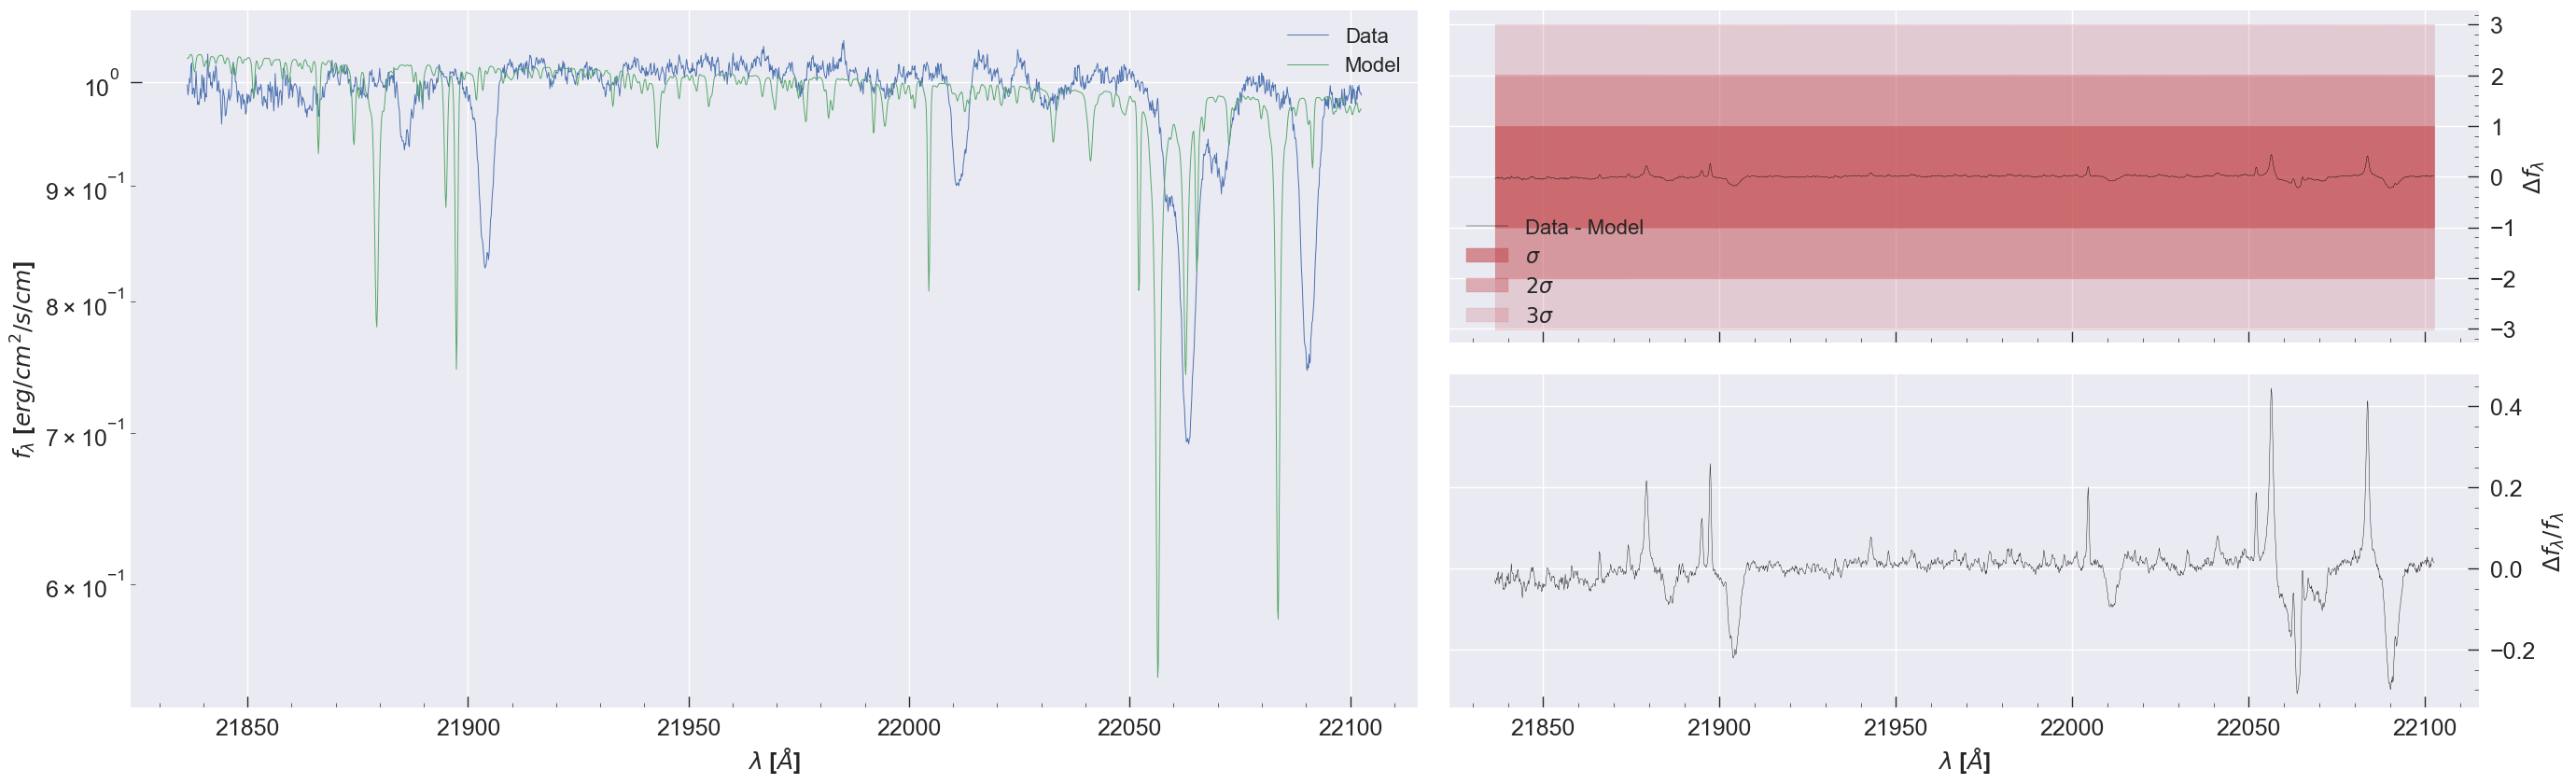

In [11]:
import scipy.stats as st

# ranges = [[3000, 5000], [4.0, 6.0], [0, 0.5]]  # T, logg, Z
emu = Emulator.load("starfish_hdf5\\F_IGRINS_K_emu.hdf5")

data = Spectrum.load("starfish_hdf5\\Anon1_m081.hdf5")

temp_param = 4400
logg_param = 4.5
amp = 0.01
ls = 2

model = SpectrumModel(
    "starfish_hdf5\\F_IGRINS_K_emu.hdf5",
    data,
    grid_params=[temp_param, logg_param, 0],
    Av=0,
    # vsini=18,
    # vz=92,
    global_cov=dict(log_amp=amp, log_ls=ls),
    norm=True,
    name='Anon1'
)

model.plot()
plt.show()

In [12]:
emu

Emulator
--------
Name: starfish_hdf5\F_IGRINS_K_emu
Trained: True
lambda_xi: 0.998
Variances:
	24216.99
	48893.49
	12931.30
	13681.11
	7455.29
	10314.77
	9216.17
	20404.93
	3475.79
Lengthscales:
	[ 412.42  1.25  1.62 ]
	[ 358.75  1.74  1.50 ]
	[ 297.44  1.38  2.44 ]
	[ 409.96  1.39  1.17 ]
	[ 407.39  1.44  1.33 ]
	[ 200.00  2.16  1.67 ]
	[ 394.08  1.65  1.27 ]
	[ 200.00  1.69  1.71 ]
	[ 482.18  1.61  1.00 ]
Log Likelihood: -3557.89

In [13]:
flux, cov = model()
flux
cov.diagonal()

array([1.01033932, 1.01032292, 1.01032624, ..., 1.01013532, 1.01013523,
       1.01013535])

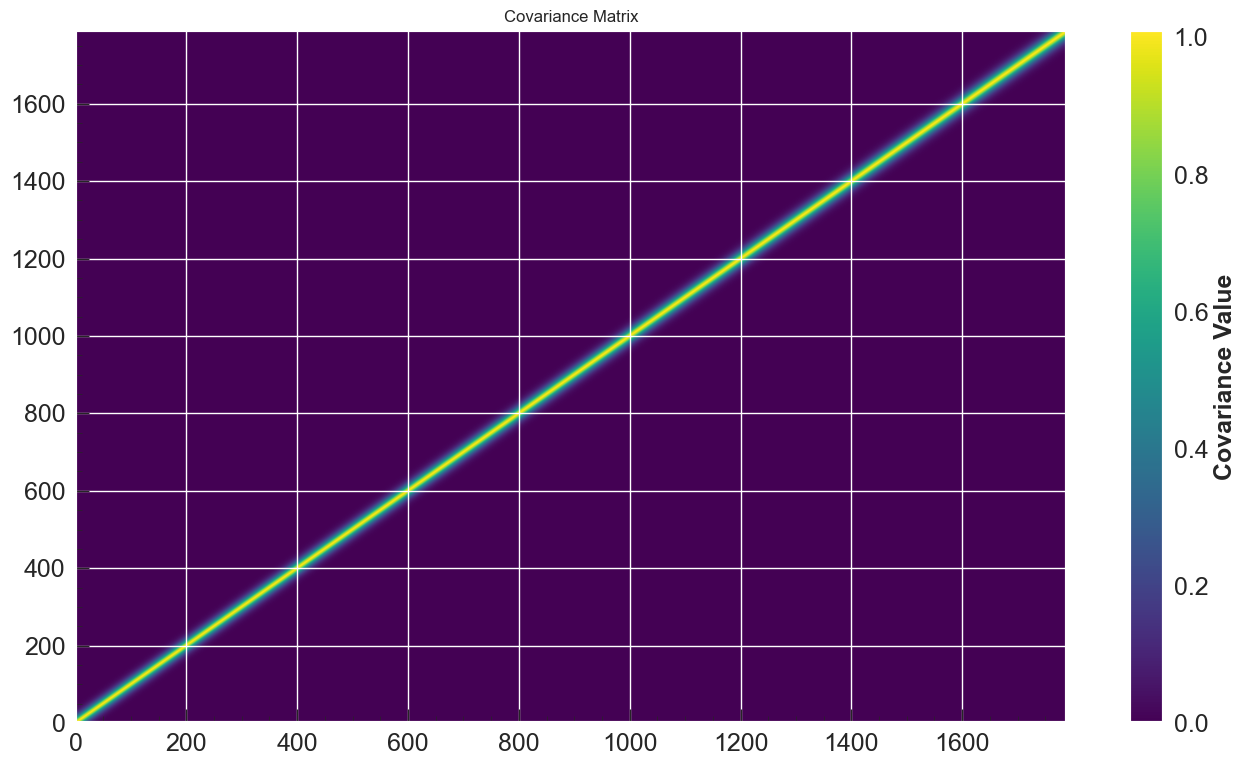

In [16]:
import matplotlib.pyplot as plt
plt.imshow(cov, cmap="viridis", origin='lower', aspect="auto", interpolation='gaussian')
plt.colorbar(label="Covariance Value")
plt.title("Covariance Matrix")
plt.show()

In [114]:
# plt.figure(figsize=(15,5))
# grid = plt.GridSpec(2, 2, width_ratios=(1.25, 1))
# axes = [
#     plt.subplot(grid[:, 0]),
#     plt.subplot(grid[0, 1]),
#     plt.subplot(grid[1, 1]),
# ]
# axes[1].tick_params(labelbottom=False)

# model_flux, model_cov = model()

# # Comparison plot
# plot_params = {"lw": 0.7}
# # plot_params.update(plot_kwargs)
# ax = axes[0]
# ax.plot(model.data.wave, model.data.flux, lw=1, label="Data")
# ax.plot(model.data.wave, model_flux, lw=1, label="Model")
# # ax.set_yscale("log")
# ax.set_xlabel(r"$\lambda$ [$\AA$]")
# ax.set_ylabel("Normalized Flux")
# ax.legend()

# # Residuals plot
# R = model.data.flux - model_flux
# std = np.sqrt(model_cov.diagonal())
# # std = np.std(R)
# resid_params = {"lw": 0.3}
# # resid_params.update(resid_kwargs)
# ax = axes[1]
# ax.plot(model.data.wave, R, c="k", lw=0.5, label="Data - Model")
# ax.fill_between(
#     model.data.wave, -std, std,
#     color="C2", alpha=0.7, lw=1, label=r"$\sigma$"
# )

# ax.fill_between(
#     model.data.wave, (2*std), (2*std),
#     color="C2", alpha=0.5, lw=1, label=r"$2\sigma$"
# )

# ax.fill_between(
#     model.data.wave, (3*std), (3*std),
#     color="C2", alpha=0.3, lw=1, label=r"$3\sigma$"
# )
# ax.set_ylim(-0.5, 0.5)
# ax.set_ylabel(r"$\Delta f$")
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")
# ax.legend()

# # Relative Error plot
# R_f = R / model.data.flux
# ax = axes[2]
# ax.plot(model.data.wave, R_f, lw=1, label="Relative Error", c="k")
# ax.set_xlabel(r"$\lambda$ [$\AA$]")
# ax.set_ylabel(r"$\Delta f_\lambda / f_\lambda$")
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")
# ax.legend()

# plt.suptitle(model.data_name)
# # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# # return axes
# plt.show()

# Numerical Optimization

In [17]:
model.freeze("logg")
model.labels  # These are the fittable parameters

('Av', 'global_cov:log_amp', 'global_cov:log_ls', 'T', 'Z')

In [18]:
priors = {"T": st.norm(3000, 100),
        "Z": st.uniform(0.0, 0.5),
        "Av": st.halfnorm(0, 0.2),
        "global_cov:log_amp": st.norm(amp, 1),
        "global_cov:log_ls": st.uniform(ls, 10),
}

In [21]:
emu

Emulator
--------
Name: starfish_hdf5\F_IGRINS_K_emu
Trained: True
lambda_xi: 0.998
Variances:
	24216.99
	48893.49
	12931.30
	13681.11
	7455.29
	10314.77
	9216.17
	20404.93
	3475.79
Lengthscales:
	[ 412.42  1.25  1.62 ]
	[ 358.75  1.74  1.50 ]
	[ 297.44  1.38  2.44 ]
	[ 409.96  1.39  1.17 ]
	[ 407.39  1.44  1.33 ]
	[ 200.00  2.16  1.67 ]
	[ 394.08  1.65  1.27 ]
	[ 200.00  1.69  1.71 ]
	[ 482.18  1.61  1.00 ]
Log Likelihood: -3557.89

In [19]:
%time model.train(priors)

ValueError: Querying emulator outside of original parameter range.

In [24]:
model.save("starfish_hdf5\\IGRINS_MAP.toml")

# MCMC Sampling

In [29]:
import emcee

emcee.__version__

'3.1.6'

In [30]:
model.load("starfish_hdf5\\IGRINS_MAP.toml")
model.freeze("global_cov")
model.labels

('Av', 'vz', 'T', 'Z')

In [32]:
# Set our walkers and dimensionality
nwalkers = 50
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {"T": 1, "Av": 0.01, "Z": 0.01, "vz": 0.1}

ball = np.random.randn(nwalkers, ndim)

for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

In [34]:
# our objective to maximize
def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)


# Set up our backend and sampler
backend = emcee.backends.HDFBackend("example_chain.hdf5")
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(priors,), backend=backend
)

In [35]:
max_n = 1000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(ball, iterations=max_n, progress=True):
    # Only check convergence every 10 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1
    # skip math if it's just going to yell at us
    if np.isnan(tau).any() or (tau == 0).any():
        continue
    # Check convergence
    converged = np.all(tau * 10 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        print(f"Converged at sample {sampler.iteration}")
        break
    old_tau = tau

emcee: Exception while calling your likelihood function:
  params: [4.03704918e-03 6.09681282e+01 2.92076295e+03 2.35388455e-02]
  args: ({'T': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E153E6C7F0>, 'Z': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E156A22DD0>, 'Av': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E153E6E4A0>, 'global_cov:log_amp': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E156A20B20>, 'global_cov:log_ls': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E156AFF280>},)
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "c:\Users\Savio\anaconda3\envs\starfish_env\lib\site-packages\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\Users\Savio\AppData\Local\Temp\ipykernel_3116\2511438741.py", line 4, in log_prob
    return model.log_likelihood(priors)
  File "c:\Users\Savio\anaconda3\envs\starfish_env\lib\site-packages\Starfish\models\spectrum_model.py", line 398, in log_likelihood
    flux, cov = self()
  File "c:\Users\Savio\anaconda3\envs\starfish_env\lib\site-packages\Starfish\models\spectrum_model.py", line 306, in __call__
    weights, weights_cov = self.emulator(self.grid_params)
  File "c:\Users\Savio\anaconda3\envs\starfish_env\lib\site-packages\Starfish\emulator\emulator.py", line 378, in __call__
    raise ValueError("Querying emulator outside of original parameter range.")
ValueError: Querying emulator outside of original parameter range.


ValueError: Querying emulator outside of original parameter range.

In [132]:
sampler.run_mcmc(backend.get_last_sample(), 100, progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]Traceback (most recent call last):
  File "c:\Users\Savio\anaconda3\envs\starfish_env\lib\site-packages\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\Users\Savio\AppData\Local\Temp\ipykernel_15792\2511438741.py", line 4, in log_prob
    return model.log_likelihood(priors)
  File "c:\Users\Savio\anaconda3\envs\starfish_env\lib\site-packages\Starfish\models\spectrum_model.py", line 398, in log_likelihood
    flux, cov = self()
  File "c:\Users\Savio\anaconda3\envs\starfish_env\lib\site-packages\Starfish\models\spectrum_model.py", line 306, in __call__
    weights, weights_cov = self.emulator(self.grid_params)
  File "c:\Users\Savio\anaconda3\envs\starfish_env\lib\site-packages\Starfish\emulator\emulator.py", line 387, in __call__
    mu = v21 @ np.linalg.solve(self.v11, self.w_hat)
  File "c:\Users\Savio\anaconda3\envs\starfish_env\lib\site-packages\numpy\linalg\linalg.py", line 409, in solve
  

emcee: Exception while calling your likelihood function:
  params: [1.77102921e-02 4.86347774e+03 4.41064217e-03]
  args: ({'T': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018483F57D60>, 'Z': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018480804BE0>, 'Av': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018483C98D00>, 'global_cov:log_amp': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000184808050C0>, 'global_cov:log_ls': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018483C9B490>},)
  kwargs: {}
  exception:


KeyboardInterrupt: 

# MCMC Chain Analysis

In [ ]:
import arviz as az
import corner

print(az.__version__, corner.__version__)

0.20.0 2.2.3


In [ ]:
reader = emcee.backends.HDFBackend("example_chain.hdf5")
full_data = az.from_emcee(reader, var_names=model.labels)

In [ ]:
az.plot_trace(full_data)

In [ ]:
tau = reader.get_autocorr_time(tol=0)
burnin = int(tau.max())
thin = int(0.3 * np.min(tau))
burn_samples = reader.get_chain(discard=burnin, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, thin=thin)

dd = dict(zip(model.labels, burn_samples.T))
burn_data = az.from_dict(dd)



In [ ]:
az.plot_trace(burn_data)

In [ ]:
az.summary(burn_data)

In [ ]:
# See https://corner.readthedocs.io/en/latest/pages/sigmas.html#a-note-about-sigmas
sigmas = ((1 - np.exp(-0.5)), (1 - np.exp(-2)))
corner.corner(
    burn_samples.reshape((-1, 3)),
    labels=model.labels,
    quantiles=(0.05, 0.16, 0.84, 0.95),
    levels=sigmas,
    show_titles=True,
)

In [ ]:
best_fit = dict(az.summary(burn_data)["mean"])
model.set_param_dict(best_fit)
model

In [ ]:
model.plot()